# 画像を漫画風にする
[ここ](https://algorithm.joho.info/image-processing/manga-ka-fu/)を参考にする

- グレースケール化（画像読み込み時）
- エッジ検出
- 多値化（３値）
- 灰色画素値のみトーンに置き換える
- 輪郭画像との合成

## 画像の読み込み

In [1]:
import numpy as np
from PIL import Image, ImageFilter, ImageOps

import matplotlib.pyplot as plt

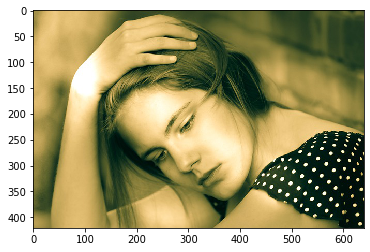

In [2]:
# 元画像の読み込み
img = Image.open('data/girl.jpg')
plt.imshow(img)

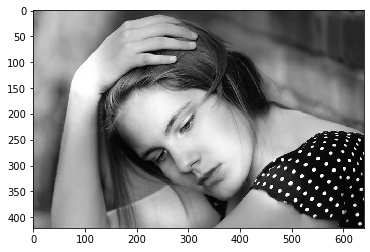

In [3]:
r = 0.9 # default 1
_gamma = 255*(np.array(img.convert('L'))/255)**(1/r)
img_gamma = Image.fromarray(_gamma.astype(np.uint8))
plt.imshow(img_gamma, cmap='gray')

In [73]:
def _gamma(img: Image, r: float=1.0) -> Image:
    """
    ガンマ変換を行う
    """
    _tmp = 255*(np.array(img.convert('L'))/255)**(1/r)
    img_gamma = Image.fromarray(_tmp.astype(np.uint8))
    return img_gamma

In [5]:
# _gamma(img, r=0.9)

## エッジ検出

In [6]:
# 8近傍ラプラシアンフィルタ
# https://algorithm.joho.info/image-processing/laplacian-filter/
_laplacian = np.array([[1,  1, 1],
                       [1, -8, 1],
                       [1,  1, 1]]).flatten()
laplacian_kernel = ImageFilter.Kernel(size=(3,3), kernel=_laplacian, scale=1)

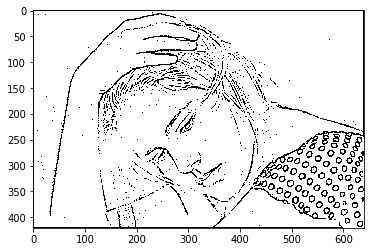

In [7]:
img_edge = 255 - np.array(img_gamma.filter(ImageFilter.GaussianBlur(radius=1)).filter(laplacian_kernel))
img_edge = np.where(img_edge <= 240, 0, 255).astype(np.uint8)
img_edge = Image.fromarray(img_edge)
plt.imshow(img_edge, cmap='gray')

In [86]:
def _edge_detection(img: Image):
    """
    エッジ検出を行う
    """
    # 8近傍ラプラシアンフィルタ
    # https://algorithm.joho.info/image-processing/laplacian-filter/
    _laplacian = np.array([[1,  1, 1],
                           [1, -8, 1],
                           [1,  1, 1]]).flatten()
    laplacian_kernel = ImageFilter.Kernel(size=(3,3), kernel=_laplacian, scale=1)

    img_edge = 255 - np.array(img_gamma.filter(ImageFilter.GaussianBlur(radius=1)).filter(laplacian_kernel))
    img_edge = np.where(img_edge <= 240, 0, 255).astype(np.uint8) # 2値化
    img_edge = Image.fromarray(img_edge)
    return img_edge    

In [72]:
# _edge_detection(img_gamma)

## 多値化（３値化）

In [10]:
from skimage import filters

In [11]:
# 3値にする
bright = 20 # default 40
gray = 40 # default 40
_th = filters.threshold_otsu(np.array(img_gamma))
th1 = _th - bright # 閾値1
th2 = _th - bright+gray # 閾値2

img_array = np.array(img_gamma)
_tmp = np.where(img_array < th1, 0, img_array)
_tmp = np.where((th1 <= _tmp) & (_tmp < th2), 128, _tmp)
img_3valued = Image.fromarray(np.where(th2 <= _tmp, 255, _tmp))

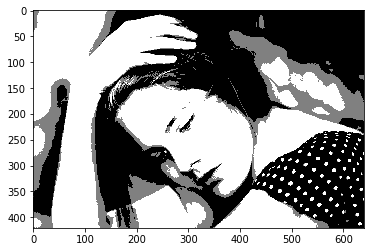

In [12]:
plt.imshow(img_3valued, cmap='gray')

In [87]:
def _gray2ternary(img: Image, bright: int = 20, grayzone: int = 40) -> Image:
    """
    gray画像から３値化する
    """
    _th = filters.threshold_otsu(np.array(img))
    th1 = _th - bright # 閾値1
    th2 = _th - bright+grayzone # 閾値2

    _tmp = np.array(img)
    _tmp = np.where(_tmp < th1, 0, _tmp)
    _tmp = np.where((th1 <= _tmp) & (_tmp < th2), 128, _tmp)
    result = np.where(th2 <= _tmp, 255, _tmp)
    return Image.fromarray(result)

In [88]:
# _gray2ternary(img_gamma)

## 灰色画素値のみトーンに置き換える

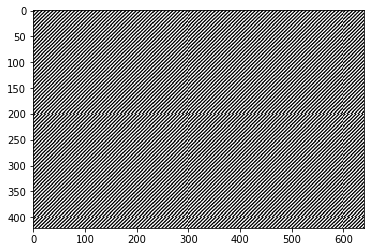

In [15]:
_tone = Image.open('data/screen.jpg').convert('L')
# toneの大きさが足りないので、大きくする
i = np.ceil(max(np.array(img_3valued.size)/np.array(_tone.size))).astype(int) # tone画像何枚分か計算
tone_tile = np.tile(np.array(_tone), (i,i))[:img_3valued.size[1], :img_3valued.size[0]]
plt.imshow(tone_tile, cmap='gray')

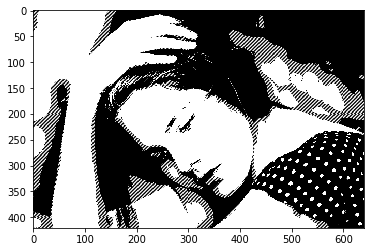

In [16]:
img_tone = np.where(np.array(img_3valued) == 128, tone_tile, np.array(img_3valued))
img_tone = Image.fromarray(img_tone)
plt.imshow(img_tone, cmap='gray')

In [74]:
def _spreading_screentone(img: Image, screen_tone: Image) -> Image:
    """
    img画像にトーンを貼る
    """
    # toneの大きさが足りないので、大きくする
    i = np.ceil(max(np.array(img.size)/np.array(screen_tone.size))).astype(int) # tone画像何枚分か計算
    tone_tile = np.tile(np.array(screen_tone), (i,i))[:img.size[1], :img.size[0]]
    img_array = np.array(img)
    img_tone = np.where(img_array == 128, tone_tile, img_array)
    return Image.fromarray(img_tone)

In [78]:
# _tone = Image.open('data/screen.jpg').convert('L')
# _spreading_screentone(img_3valued, _tone)

## トーンを貼った画像にエッジをつける

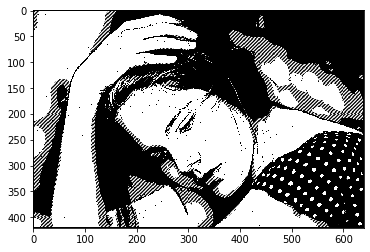

In [79]:
cartoon_style = np.where(np.array(img_edge) == 0, 0, np.array(img_tone))
img_cartoon_style = Image.fromarray(cartoon_style)
plt.imshow(img_cartoon_style, cmap='gray')

In [80]:
def make_cartoon_style(img: Image, screen_tone: Image, r: float=1, bright: int=20, grayzone: int=40) -> Image:
    img_gamma = _gamma(img, r) # 明るさを調節
    img_edge = _edge_detection(img_gamma) # エッジ検出(ラプラシアンフィルタ)
    img_ternary = _gray2ternary(img_gamma, bright, grayzone) # 3値化
    img_spreded_tone = _spreading_screentone(img_ternary, screen_tone) # トーンを貼る
    # 漫画風にする
    cartoon_style = np.where(np.array(img_edge) == 0, 0, np.array(img_spreded_tone))
    img_cartoon_style = Image.fromarray(cartoon_style)
    return img_cartoon_style

In [85]:
# _tone = Image.open('data/screen.jpg').convert('L')
# make_cartoon_style(img, _tone)

## 【追加】擬音をつけてみる
素材：https://dddfont.com/
- 擬音の箇所をマスクとして作成
- マスクをかける

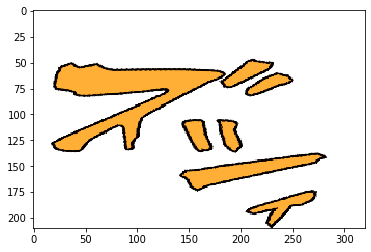

In [59]:
img_onomatopoeia = Image.open('data/onomatopoei_zushi.png').convert('RGBA').rotate(-30)
# サイズを調整
size = (np.array(img_cartoon_style.size)/2).astype(int)
img_onomatopoeia = img_onomatopoeia.resize(size)
plt.imshow(img_onomatopoeia, cmap='gray')

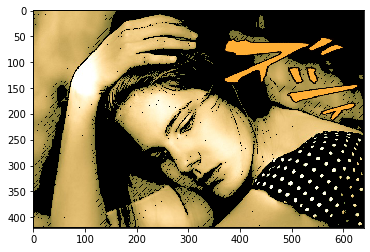

In [60]:
_tmp = img_cartoon_style.copy().convert('RGB')
_tmp = Image.fromarray(np.where(np.array(_tmp) != 0, np.array(img), _tmp))
_tmp.paste(img_onomatopoeia, (350, 5), mask=img_onomatopoeia)
result = _tmp
plt.imshow(result)

In [24]:
result.save('data/cartoon_style.jpg', format='JPEG')